## 环境准备

In [1]:
import os
os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'

In [2]:
import torch

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

torch.set_default_device(device)
print(f"Using device = {torch.get_default_device()}")

Using device = cuda:0


## 数据获取和预处理

In [3]:
from datasets import load_dataset

dataset = load_dataset("Hacker0x01/hackerone_disclosed_reports")
dataset = dataset.filter(
    lambda example:
    example["title"] is not None and
    example["vulnerability_information"] is not None and
    example["weakness"] is not None
)
print(dataset)

/root/miniforge3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'created_at', 'substate', 'vulnerability_information', 'reporter', 'team', 'has_bounty?', 'visibility', 'disclosed_at', 'weakness', 'original_report_id', 'vote_count', 'structured_scope'],
        num_rows: 8904
    })
    test: Dataset({
        features: ['id', 'title', 'created_at', 'substate', 'vulnerability_information', 'reporter', 'team', 'has_bounty?', 'visibility', 'disclosed_at', 'weakness', 'original_report_id', 'vote_count', 'structured_scope'],
        num_rows: 1128
    })
    validation: Dataset({
        features: ['id', 'title', 'created_at', 'substate', 'vulnerability_information', 'reporter', 'team', 'has_bounty?', 'visibility', 'disclosed_at', 'weakness', 'original_report_id', 'vote_count', 'structured_scope'],
        num_rows: 1119
    })
})


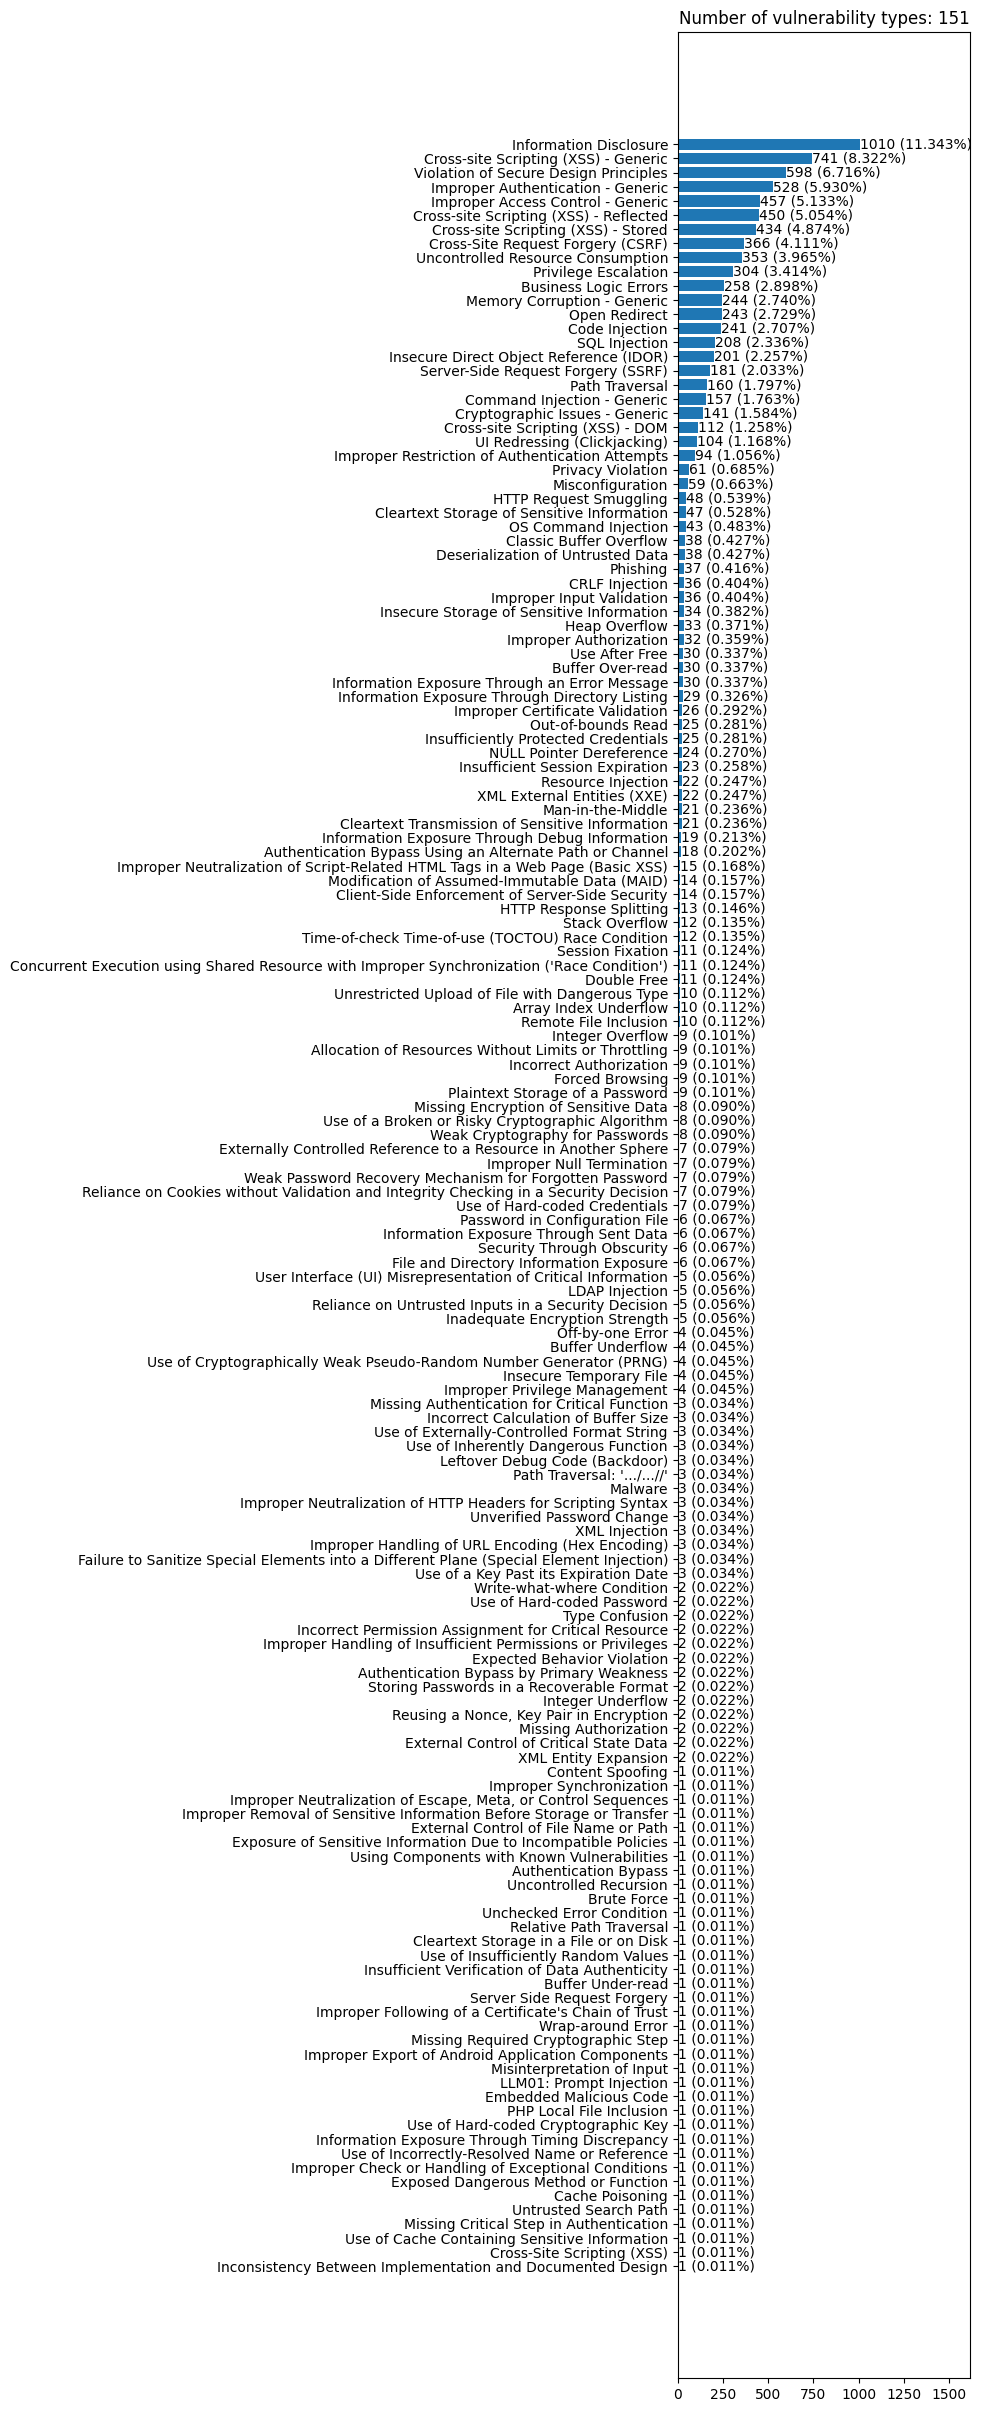

In [4]:
import matplotlib.pyplot as plt
from collections import Counter

weakness_types = [item["weakness"]["name"] for item in dataset["train"]]
type_counter = Counter(weakness_types)
sorted_counts = sorted(type_counter.items(), key=lambda x: x[1])
labels = [x[0] for x in sorted_counts]
values = [x[1] for x in sorted_counts]
total = sum(values)

plt.figure(figsize=(10, 24))
plt.bar_label(
    plt.barh(labels, values),
    labels= [f"{v} ({v/total:.3%})" for v in values],
)
plt.xlim(right=max(values)*1.6)
plt.tight_layout()
plt.title(f"Number of vulnerability types: {len(labels)}")
plt.show()

In [5]:
main_types = [k for k,v in type_counter.items() if v > total*0.0024]
main_types.append("Other")
print(f"漏洞类型数量: {len(main_types)}")
dataset = dataset.map(lambda example: {'label': main_types.index(example["weakness"]["name"]) if example["weakness"]["name"] in main_types else len(main_types)-1 })

漏洞类型数量: 48


In [6]:
from transformers import BertTokenizer
import transformers

tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")

def tokenize_function(example):
    return tokenizer(example["title"], example["vulnerability_information"], padding=True, max_length=512, truncation=True)

verbosity = transformers.logging.get_verbosity(); transformers.logging.set_verbosity_error()
tokenized_datasets = dataset.map(tokenize_function, batched=True)
transformers.logging.set_verbosity(verbosity)
tokenized_datasets = tokenized_datasets.select_columns(['input_ids', 'token_type_ids', 'attention_mask', 'label'])
tokenized_datasets.set_format("torch")

for item in tokenized_datasets["train"]:
    print(f"item: {item}")
    print(f'tokens: {tokenizer.convert_ids_to_tokens(item["input_ids"])}')
    break

item: {'input_ids': tensor([  101,  5293, 20786,  4957,  2025,  4654,  8197,  4892,  2044, 10373,
         2689,  1012,   102,  1045,  2179,  1037, 19204,  3335,  9563, 28450,
         1999, 11834,  3126, 20179,  1012,  4012,  1010,  2043,  2057, 25141,
        20786,  2005,  1037,  5310,  1037,  4957,  2003,  2741,  2000,  1996,
         5068, 10373,  4769,  2021, 27523,  3366,  2009,  3961, 15171,  1998,
        10373,  2003,  7172,  2011,  5310,  2013,  4292,  5997,  2059,  2205,
         2008,  2214, 19204,  1031, 25141,  4957,  1033,  2741,  2012,  2214,
        10373,  4769,  3464,  9398,  1012,  1001,  1037,  2488,  7526,  1015,
         1011,  5310,  2224, 25141,  3444,  2000,  2131, 25141,  4957,  1031,
        10373,  1024,  4385,  1030,  1060,  1012,  4012,  1033,  1016,  1011,
         5310,  2234,  2000,  2113,  2055,  2010,  2214, 20786,  2061,  3961,
         1996,  4957, 15171,  1998,  1996, 19204,  2025,  4654, 20781,  2015,
         1017,  1011,  2085,  5310,  3431,  

In [7]:
from torch.utils.data import DataLoader
import torch

generator = torch.Generator(device=device)

train_dataloader = DataLoader(tokenized_datasets["train"], shuffle=True, batch_size=16, generator=generator)
validation_dataloader = DataLoader(tokenized_datasets["validation"], shuffle=True, batch_size=16, generator=generator)
test_dataloader = DataLoader(tokenized_datasets["test"], shuffle=True, batch_size=16, generator=generator)

for batch in train_dataloader:
    print({k: v.shape for k, v in batch.items()})
    break

{'input_ids': torch.Size([16, 512]), 'token_type_ids': torch.Size([16, 512]), 'attention_mask': torch.Size([16, 512]), 'label': torch.Size([16])}


## 定义分类模型

In [8]:
import torch.nn as nn
from transformers import BertModel

class BertClassifier(nn.Module):
    def __init__(self, num_labels):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("google-bert/bert-base-uncased")
        self.dropout = nn.Dropout(self.bert.config.hidden_dropout_prob)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, **inputs):
        outputs = self.bert(**inputs)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

model = BertClassifier(num_labels=len(main_types))

In [9]:
from transformers import BertForSequenceClassification

model_builtin = BertForSequenceClassification.from_pretrained("google-bert/bert-base-uncased", num_labels=len(main_types))

model.classifier.weight.data = model_builtin.classifier.weight.data.clone()
model.classifier.bias.data = model_builtin.classifier.bias.data.clone()

inputs = tokenizer("Hello World!", return_tensors='pt')

# 使用eval模式关闭Dropout的随机性
model.eval()
model_builtin.eval()

print( model(**inputs) == model_builtin(**inputs).logits )
print( nn.CrossEntropyLoss()( model(**inputs).view(-1, len(main_types)), torch.tensor(1).view(-1) ) == model_builtin(**inputs, labels=torch.tensor(1)).loss )

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True]],
       device='cuda:0')
tensor(True, device='cuda:0')


## 训练和保存模型

In [10]:
from torch.optim import AdamW

def train(lr, epochs, dataloader, model):
    model.train()

    loss_fct = nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr=lr)

    for epoch in range(epochs):
        for batch in dataloader:
            inputs = {
                "input_ids": batch["input_ids"], 
                "token_type_ids": batch['token_type_ids'], 
                "attention_mask": batch["attention_mask"]
            }
            outputs = model(**inputs)
            batch_loss = loss_fct(outputs, batch["label"])
            batch_loss.backward()
            optimizer.step()
            optimizer.zero_grad()

In [11]:
from torch.optim import AdamW
from tqdm.auto import tqdm

def train(lr, epochs, model, train_dataloader, validation_dataloader):
    loss_fct = nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr=lr)

    train_losses, train_accs, val_losses, val_accs = [],[],[],[]
    best_val_acc = 0.0
    
    pbar = tqdm(total=epochs * len(train_dataloader))

    for epoch in range(epochs):
        model.train()
        train_loss, train_correct = 0, 0
        for batch in train_dataloader:
            inputs = {
                "input_ids": batch["input_ids"], 
                "token_type_ids": batch['token_type_ids'], 
                "attention_mask": batch["attention_mask"]
            }
            outputs = model(**inputs)
            batch_loss = loss_fct(outputs, batch["label"])
            batch_loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += batch_loss.item()
            train_correct += (outputs.argmax(1) == batch["label"]).sum().item()

            pbar.set_postfix({'lr':lr, 'epoch': f'{epoch + 1}/{epochs}', 'batch_loss': batch_loss.item(), 'best_val_acc': f'{best_val_acc:.3%}' })
            pbar.update(1)


        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for batch in validation_dataloader:
                inputs = {
                    "input_ids": batch["input_ids"], 
                    "token_type_ids": batch['token_type_ids'], 
                    "attention_mask": batch["attention_mask"]
                }
                outputs = model(**inputs)
                batch_loss = loss_fct(outputs, batch["label"])
                
                val_loss += batch_loss.item()
                val_correct += (outputs.argmax(1) == batch["label"]).sum().item()


        train_losses.append( train_loss / len(train_dataloader) )
        train_accs.append( train_correct / len(train_dataloader.dataset) )
        val_losses.append( val_loss / len(validation_dataloader) )
        val_accs.append( val_correct / len(validation_dataloader.dataset) )

        if val_accs[-1] > best_val_acc:
            best_val_acc = val_accs[-1]
            torch.save(model.state_dict(), f"model_lr_{lr}_epoch_{epoch+1}_acc_{best_val_acc:.5}.pt")
    
    return train_losses, train_accs, val_losses, val_accs

In [12]:
lr_list = [5e-5, 3e-5, 2e-5]
train_losses_list, train_accs_list, val_losses_list, val_accs_list = [],[],[],[]
for lr in lr_list:
    model = BertClassifier(num_labels=len(main_types))
    train_losses, train_accs, val_losses, val_accs = train(lr=lr, epochs=10, model=model, train_dataloader=train_dataloader, validation_dataloader=validation_dataloader)
    train_losses_list.append(train_losses)
    train_accs_list.append(train_accs)
    val_losses_list.append(val_losses)
    val_accs_list.append(val_accs)

100%|██████████| 5570/5570 [2:18:08<00:00,  1.49s/it, lr=2e-5, epoch=10/10, batch_loss=0.057, best_val_acc=59.875%]   


[[2.4376792826387144, 1.6779602061910304, 1.3293001878892925, 1.003384449270084, 0.7170467701217217, 0.486081461905363, 0.3408824729681336, 0.25588929336819016, 0.18145530030325296, 0.15886258612482188], [2.5165262029671798, 1.7007133782016952, 1.3335700619370547, 1.0003456627177594, 0.7170255590009518, 0.48973004156104966, 0.32913930589062307, 0.24134143233580158, 0.16173055350171867, 0.1295898124221144], [2.662268315226214, 1.7946453817870929, 1.4372393029810495, 1.142284934674816, 0.8625124587645651, 0.6376722407940261, 0.45490325188775893, 0.32863660001227735, 0.23816298579385828, 0.187198048942393]], [[0.36253369272237196, 0.5429020664869721, 0.6366801437556154, 0.7242812219227314, 0.8013252470799641, 0.8660152740341419, 0.9079065588499551, 0.9334007187780773, 0.9508086253369272, 0.9574348607367476], [0.3478212039532794, 0.5444743935309974, 0.6430817610062893, 0.7329290206648698, 0.8121069182389937, 0.8712938005390836, 0.9167789757412399, 0.9377807726864331, 0.9605795148247979, 0.

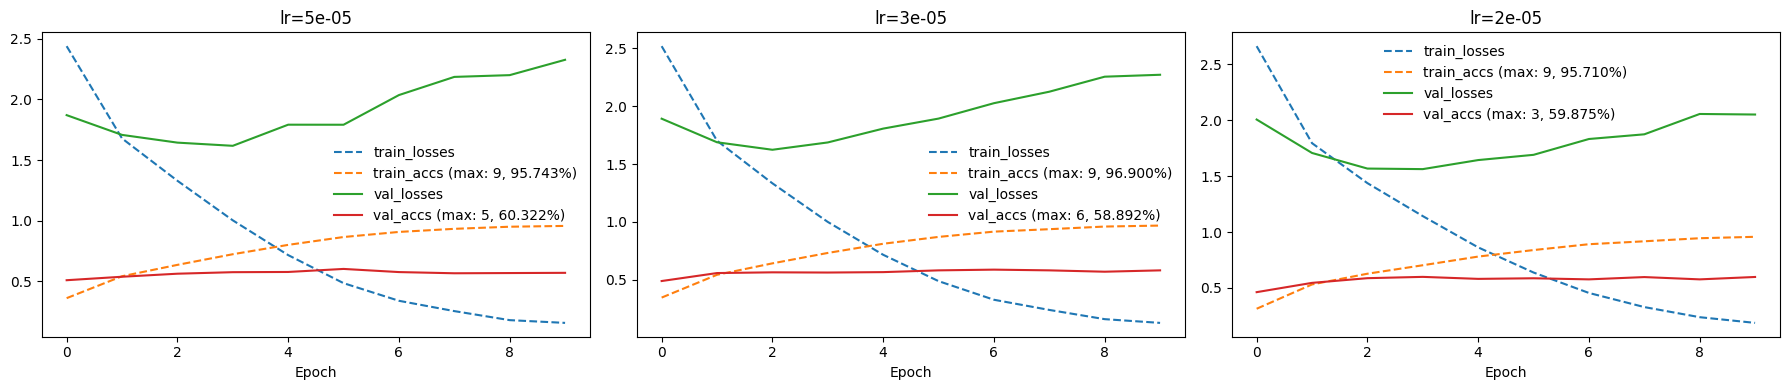

In [30]:
print(f"{train_losses_list}, {train_accs_list}, {val_losses_list}, {val_accs_list}")

def plot_subplot(ax, title, train_losses, train_accs, val_losses, val_accs):
    ax.plot(train_losses, label="train_losses", linestyle='--')
    ax.plot(train_accs, label=f"train_accs (max: {train_accs.index(max(train_accs))}, {max(train_accs):.3%})", linestyle='--')
    ax.plot(val_losses, label="val_losses")
    ax.plot(val_accs, label=f"val_accs (max: {val_accs.index(max(val_accs))}, {max(val_accs):.3%})")
    ax.legend(frameon=False)
    ax.set_xlabel("Epoch")
    ax.set_title(title)

fig, axes = plt.subplots(1, 3, figsize=(18, 4))
for idx, lr in enumerate(lr_list):
    plot_subplot(
        axes[idx], 
        f"lr={lr}", 
        train_losses_list[idx], 
        train_accs_list[idx], 
        val_losses_list[idx], 
        val_accs_list[idx]
    )
plt.tight_layout()
plt.show()